<a href="https://colab.research.google.com/github/Ryan-Passos/yfinance---Carteira-de-Investimentos/blob/main/APS_otimizacao_de_sistemas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Selecione o nível de risco desejado:
1- Baixo risco (cerca de 20%)
2- Médio risco (cerca de 50%)
3- Alto risco (cerca de 70%)
Digite o número correspondente ao nível de risco: 3


[*********************100%***********************]  10 of 10 completed


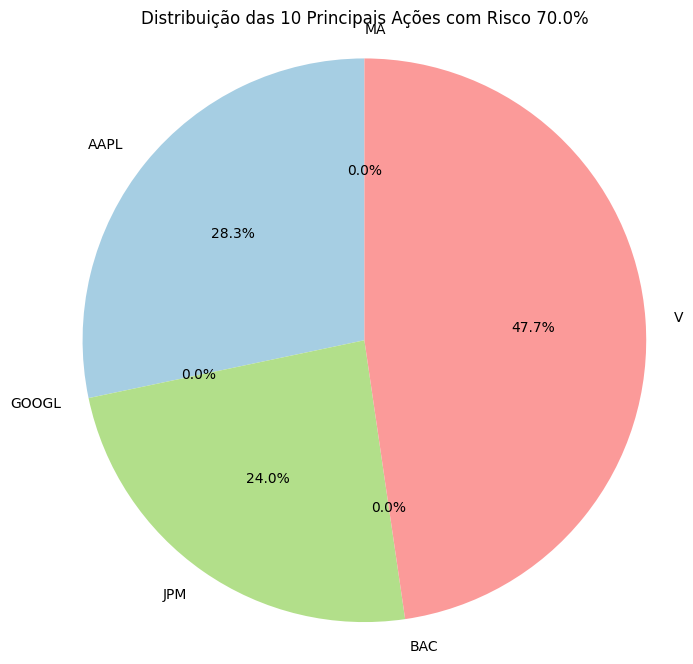

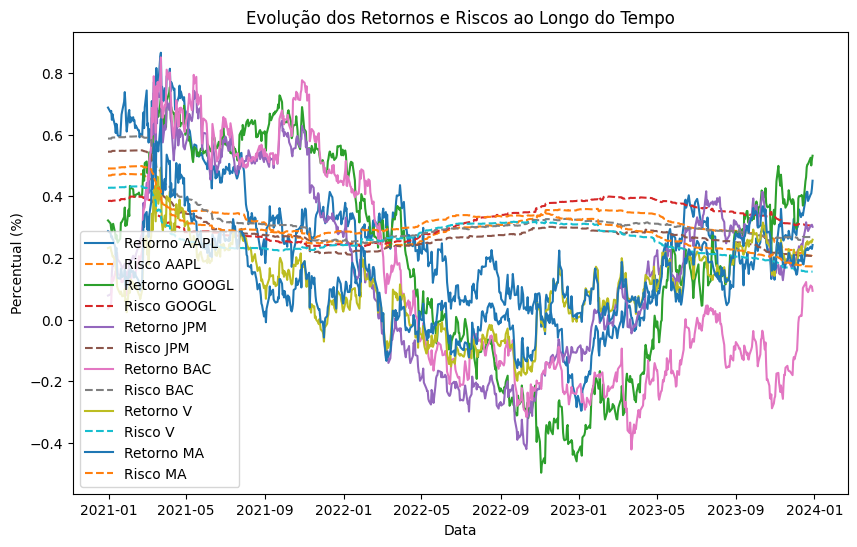

VaR: -3.24%, CVaR: -4.69%


In [39]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Função para coletar dados históricos de ativos
def coletar_dados_acoes(tickers, start='2020-01-01', end='2024-01-01'):
    dados = yf.download(tickers, start=start, end=end)['Adj Close']
    return dados

# Função para calcular retorno anualizado e volatilidade
def calcular_retorno_volatilidade(dados):
    retornos = dados.pct_change().mean() * 252  # Retorno anualizado
    volatilidade = dados.pct_change().std() * np.sqrt(252)  # Volatilidade anualizada
    return retornos, volatilidade

# Função de otimização da carteira ajustada
def otimizacao_carteira(returns, max_risk, dados):
    num_assets = len(returns)

    # Função objetivo para maximizar retorno e minimizar risco
    def objetivo(weights):
        portfolio_return = np.dot(weights, returns)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(np.cov(dados.pct_change().dropna().T), weights)))
        return -portfolio_return / portfolio_risk if portfolio_risk <= max_risk else np.inf

    # Restrições e limites
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Pesos somando 1
    bounds = [(0, 1)] * num_assets  # Pesos entre 0 e 1
    initial_weights = np.ones(num_assets) / num_assets  # Pesos iguais

    # Execução da otimização
    resultado = minimize(objetivo, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return resultado.x if resultado.success else None

# Função para selecionar o nível de risco
def selecionar_nivel_risco():
    """
    Solicita ao usuário que selecione um nível de risco e retorna o valor correspondente.
    """
    print("Selecione o nível de risco desejado:")
    print("1- Baixo risco (cerca de 20%)")
    print("2- Médio risco (cerca de 50%)")
    print("3- Alto risco (cerca de 70%)")

    opcao = int(input("Digite o número correspondente ao nível de risco: "))

    if opcao == 1:
        return 0.20  # Baixo risco
    elif opcao == 2:
        return 0.50  # Médio risco
    elif opcao == 3:
        return 0.70  # Alto risco
    else:
        print("Opção inválida, por favor selecione entre 1, 2 ou 3.")
        return selecionar_nivel_risco()

# Função para calcular VaR
def calcular_var(dados, alpha=0.05):
    retornos = dados.pct_change().dropna()
    var = retornos.quantile(alpha)  # Retorna o VaR como um valor escalar
    return var.values[0] if isinstance(var, pd.Series) else var  # Certifica-se que é um valor escalar

# Função para calcular CVaR
def calcular_cvar(dados, alpha=0.05):
    retornos = dados.pct_change().dropna()
    var = calcular_var(dados, alpha)
    cvar = retornos[retornos <= var].mean()  # Retorna o CVaR como um valor escalar
    return cvar.values[0] if isinstance(cvar, pd.Series) else cvar  # Certifica-se que é um valor escalar

# Função para plotar os resultados
def plotar_resultados(carteira_otimizada, nivel_risco_selecionado, dados):
    # Verificar se os pesos somam 1 e normalizar
    pesos_normalizados = carteira_otimizada['Peso'] / carteira_otimizada['Peso'].sum()

    # Gráfico de pizza - Distribuição de ativos (10 principais ativos)
    plt.figure(figsize=(8, 8))
    plt.pie(pesos_normalizados, labels=carteira_otimizada['Ação'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title(f'Distribuição das 10 Principais Ações com Risco {nivel_risco_selecionado*100:.1f}%')
    plt.axis('equal')  # Assegura que o gráfico de pizza seja um círculo
    plt.show()

    # Gráfico de linhas - Evolução de retornos e riscos ao longo do tempo
    plt.figure(figsize=(10, 6))
    rolling_returns = dados.pct_change().rolling(window=252).mean() * 252
    rolling_volatility = dados.pct_change().rolling(window=252).std() * np.sqrt(252)

    for ticker in carteira_otimizada['Ação']:
        plt.plot(rolling_returns[ticker], label=f'Retorno {ticker}')
        plt.plot(rolling_volatility[ticker], label=f'Risco {ticker}', linestyle='--')

    plt.title('Evolução dos Retornos e Riscos ao Longo do Tempo')
    plt.xlabel('Data')
    plt.ylabel('Percentual (%)')
    plt.legend()
    plt.show()

# Função para plotar a fronteira eficiente
def plotar_fronteira_eficiente(dados):
    # Placeholder para a implementação da fronteira eficiente
    pass

if __name__ == "__main__":
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NFLX', 'JPM', 'BAC', 'V', 'MA']

    nivel_risco_selecionado = selecionar_nivel_risco()
    dados = coletar_dados_acoes(tickers)

    retornos, volatilidade = calcular_retorno_volatilidade(dados)
    pesos_ideais = otimizacao_carteira(retornos, nivel_risco_selecionado, dados)

    if pesos_ideais is not None:
        carteira = pd.DataFrame({'Ação': tickers, 'Peso': pesos_ideais})
        carteira = carteira[carteira['Peso'] > 0]  # Filtrar ações com peso zero
        plotar_resultados(carteira, nivel_risco_selecionado, dados)

        var = calcular_var(dados)
        cvar = calcular_cvar(dados)
        # Agora é garantido que var e cvar são escalares
        print(f'VaR: {var:.2%}, CVaR: {cvar:.2%}')
    else:
        print("A otimização da carteira falhou.")
